## Repeated Runs

To run the same simulation ten times, while guaranteeing replicability, we use a simple index (0...9) as the simulation's seed. Note that when the seed is not otherwise specified, 1234567 is used.

Average throughput time of customers for each of the 10 runs is printed out, along with a barplot graphic; this can be easily done for all other statistics, this is only a demo.

In [16]:
# !pip install matplotlib

In [17]:

import statistics

1 0
Data for run 1.
The average Customer visit lasted a total of 11077.9 seconds, or 184.63 minutes.

1 1
Data for run 2.
The average Customer visit lasted a total of 10447.86 seconds, or 174.13 minutes.

1 2
Data for run 3.
The average Customer visit lasted a total of 10588.44 seconds, or 176.47 minutes.

1 3
Data for run 4.
The average Customer visit lasted a total of 10970.83 seconds, or 182.85 minutes.

1 4
Data for run 5.
The average Customer visit lasted a total of 10436.25 seconds, or 173.94 minutes.

1 5
Data for run 6.
The average Customer visit lasted a total of 10432.09 seconds, or 173.87 minutes.

1 6
Data for run 7.
The average Customer visit lasted a total of 10149.09 seconds, or 169.15 minutes.

1 7
Data for run 8.
The average Customer visit lasted a total of 11186.44 seconds, or 186.44 minutes.

1 8
Data for run 9.
The average Customer visit lasted a total of 10620.86 seconds, or 177.01 minutes.

1 9
Data for run 10.
The average Customer visit lasted a total of 10652.96

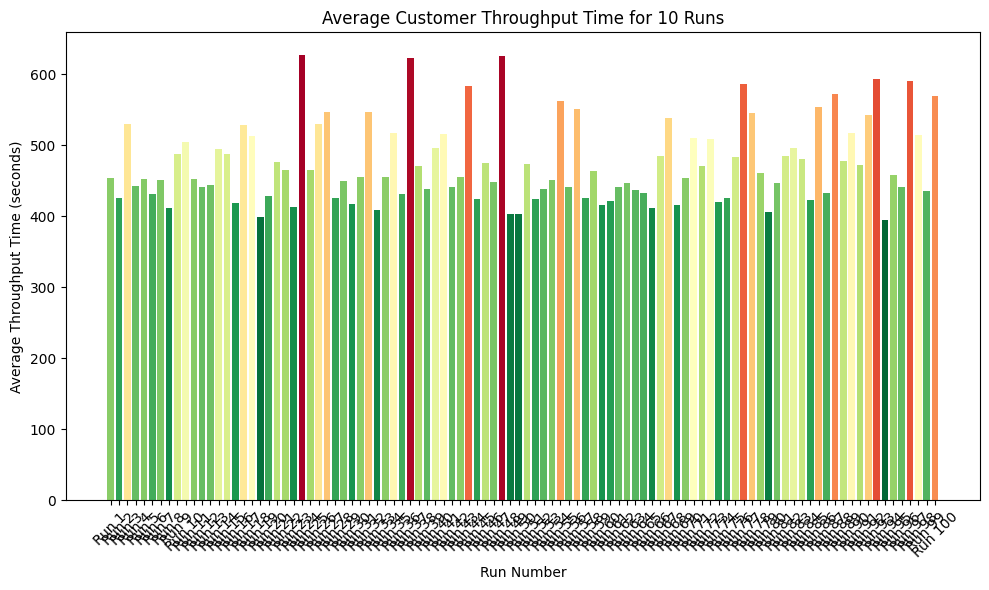

In [72]:
import salabim as sim
import matplotlib.pyplot as plt


    
    # The index is used both for the replication and the random seed
dict_checkout_number = {}
for checkout_number in [1,2,3,4,5,6,7,8,9,10]:
    # Initialize throughput_times list for graphic
    average_throughput_times = []
    for replication_number in range(100):
        print(checkout_number,replication_number)
        # Environment must be reset every time we start a run
        sim.reset()        
        env = sim.Environment(time_unit='seconds')
        env.random_seed(replication_number)
    
        #Shopping baskets and carts:
        carts = env.Resource('carts', capacity=45) #45
        baskets = env.Resource('baskets', capacity=500)#several hundred
        cart_basket_distribution = sim.Pdf((carts, 0.8,baskets, 0.2))
        customer_basketcart_distribution_monitor = sim.Monitor("Customer basket and cart monitor")
        #shopping categories:
        # fruit_and_vegetables 
        # meat_and_fish
        # bread
        # cheese_and_dairy
        # canned_and_packed_food
        # frozen_foods
        # drinks
        item_taking_distribution = sim.Uniform(20,30)
    
        #Clerks
        #Bread and cheese use resources as they are working via counters. Checkout likely has to use queue as the customers need to choose the smallest one
        bread_clerks = env.Resource('bread_clerks', capacity=4) #4 employees, 1-6 items takes 2 min
        bread_time_distribution = sim.Exponential(2*60)
        cheese_and_dairy_clerks = env.Resource('bread_clerks', capacity=3) #3 employees, 1 min avg.
        cheese_and_dairy_time_distribution = sim.Exponential(1*60)
    
        #Checkouts
        number_of_checkouts = checkout_number
        time_per_item_distribution = sim.Exponential(1.1)
        payment_time_distribution = sim.Uniform(40, 60)
    
        #Distributions of items per customer
        fruit_and_vegetables_distribution = sim.Triangular(4, 22,10)  # min=4, mode=10, max=22
        meat_and_fish_distribution = sim.Triangular(0, 9, 4)           # min=0, mode=4, max=9
        bread_distribution = sim.Triangular(1, 10, 4)                  # min=1, mode=4, max=10
        cheese_and_dairy_distribution = sim.Triangular(1, 11, 3)       # min=1, mode=3, max=11
        canned_and_packed_food_distribution = sim.Triangular(6, 35, 17)# min=6, mode=17, max=35
        frozen_foods_distribution = sim.Triangular(2, 19, 8)           # min=2, mode=8, max=19
        drinks_distribution = sim.Triangular(1, 20, 9)                 # min=1, mode=9, max=20
    
        #Route choice distribution
    
        #Routes
        route1 = [
        "fruit_and_vegetables",
        "meat_and_fish",
        "bread",
        "cheese_and_dairy",
        "canned_and_packed_food",
        "frozen_foods",
        "drinks",
        ] #ABCDEF, 80% 
    
        route2 = [
        "meat_and_fish",
        "bread",
        "cheese_and_dairy",
        "fruit_and_vegetables",
        "canned_and_packed_food",
        "frozen_foods",
        "drinks",
        ] #BCDEFG, 20%
    
        route_distribution = sim.Pdf((route1, 0.8, route2, 0.2))
    
        ### CHANGE HERE ###
        all_customers = []
    
        class Customer(sim.Component):
            def __init__(self, *args, **kwargs):
                super().__init__(*args, **kwargs)
                self.route = route_distribution.sample()
                self.shopping_list = {
                    "fruit_and_vegetables": int(round(fruit_and_vegetables_distribution.sample())),
                    "meat_and_fish": int(round(meat_and_fish_distribution.sample())),
                    "bread": int(round(bread_distribution.sample())),
                    "cheese_and_dairy": int(round(cheese_and_dairy_distribution.sample())),
                    "canned_and_packed_food": int(round(canned_and_packed_food_distribution.sample())),
                    "frozen_foods": int(round(frozen_foods_distribution.sample())),
                    "drinks": int(round(drinks_distribution.sample())),
                }
                self.progress = 0
                self.carrying = None
                self.actions_log = []
    
                all_customers.append(self)
    
            def log_action(self, action):
                    """Helper function to log an action with the current time."""
                    self.actions_log.append((env.now(), action))
    
            def process(self):
                """"
                Process determines what the customer will do. At the start they will take a cart or basket. Afterwards they will traverse their route and take the items they need according to their shopping list. If they have finished their route (when progress is equal to the length of the shopping list), they will go to the checkout.
                """
                self.start_shopping()
                for next_product in self.route:
                    if self.shopping_list[next_product]>0:
                        self.get_product(next_product)   
                self.go_to_checkout()
    
            def start_shopping(self):
                #Get shopping cart or basket
                want_to_carry = cart_basket_distribution.sample()
                self.log_action(f"Entered cart/basket queue for {want_to_carry}")
                self.request(want_to_carry)
                customer_basketcart_distribution_monitor.tally(want_to_carry)
                self.log_action(f"Got {want_to_carry}")
                self.carrying = want_to_carry
    
            def go_to_checkout(self):
                #enter emptiest queue
                emptiest_queue = min(checkouts, key=lambda checkout: checkout.requesters().length()) 
                self.log_action(f"Entered checkout queue {emptiest_queue}")
                self.request(emptiest_queue) 
                self.log_action(f"Started checking out")
                item_scan_time = sum(time_per_item_distribution.sample() for _ in range(sum(self.shopping_list.values())))
                self.hold(item_scan_time+payment_time_distribution.sample()) #hold the customer for scanning all items and during payment
                self.log_action(f"Finished checking out")
                #return cart/basket       
                #print log if we want to debug
                '''
                if customer_to_log:
                    if self.name() == f"customer.{customer_to_log}":
                        print(self.carrying.claimers().print_info())
                        print(f"Customer's Action Log for customer {self.name()}:")
                        for time, action in self.actions_log:
                            print(self)
                            print(f"At time {time}, customer: {action}")
                '''
    
            def get_product(self, product):
                #Move to product location #<- only needed in animation
                if product == "cheese_and_dairy":
                    self.log_action(f"requesting cheese and dairy")
                    self.request(cheese_and_dairy_clerks)
                    self.log_action(f"Being helped for cheese and dairy")
                    self.hold(cheese_and_dairy_distribution.sample())
                    self.log_action(f"Got cheese and dairy")
                    self.release(cheese_and_dairy_clerks)
                elif product == "bread":
                    self.log_action(f"requesting bread")
                    self.request(bread_clerks)
                    self.log_action(f"Being helped for bread")
                    self.hold(bread_time_distribution.sample())
                    self.log_action(f"Got bread")
                    self.release(bread_clerks)
                else:
                    amount = self.shopping_list[product]
                    self.log_action(f"Getting {product}")
                    for _ in range(amount):
                        self.hold(time_per_item_distribution.sample())
                        self.log_action(f"Got {product}")
    
        #customer generation
        customer_distribution = [30, 80, 110, 90, 80, 70, 80, 90, 100, 120, 90, 40] #Expected total = 980
        for index, customer_count  in enumerate(customer_distribution):
            env.ComponentGenerator(Customer, iat=env.Exponential(3600/customer_count), at=index*60*60, duration=60*60) #assumes time in seconds
            # print(customer_count)
        customer_arrival_monitor = sim.Monitor("Customer arrival monitor")
    
        checkouts = [] #dictionary to map checkouts to clerks
        for i in range(number_of_checkouts):
            checkouts.append(env.Resource(f"checkout_clerk{i}", capacity = 1)) #3, 1.1s per item avg. payment 40-60s
    
        env.run(duration=60*60*12)
        
        ####################################
        ###### THROUGHPUT COLLECTION #######
        ####################################
        
        
        # Initializing empty throughput list
        print(f'Data for run {replication_number + 1}.')
        throughput_times = []
    
        # Loop over customers in the list
        for customer in all_customers:
            # If the customer's last action is not 'Finished checking out', they aren't taken into account
            if customer.actions_log[-1][1] != 'Finished checking out':
                continue
            
            first_action_time = customer.actions_log[0][0]
            last_action_time = customer.actions_log[-1][0]
            # Throughput calculation and appending to main list
            throughput_time = last_action_time - first_action_time
            throughput_times.append(throughput_time)
    
        average_throughput = sum(throughput_times) / len(throughput_times)
        # Append the average throughput to the list for the graphic
        average_throughput_times.append(average_throughput)
    
        print(f'The average Customer visit lasted a total of {round(average_throughput, 2)} seconds, or {round(average_throughput/60, 2)} minutes.\n')
    dict_checkout_number[f"Checkouts_{checkout_number}"] = average_throughput_times
##################
### GRAPH CODE ###
##################


colors = []
max_time = max(average_throughput_times)
min_time = min(average_throughput_times)

# Create colors based on the throughput time (green for shorter times, red for longer)
for time in average_throughput_times:
    normalized = (time - min_time) / (max_time - min_time)  # Normalize between 0 and 1
    colors.append(plt.cm.RdYlGn_r(normalized))  # Using RdYlGn_r colormap (green to red)

run_numbers = [f"Run {i+1}" for i in range(len(average_throughput_times))]

plt.figure(figsize=(10, 6))
plt.bar(run_numbers, average_throughput_times, color=colors)

# Adding title and labels
plt.title('Average Customer Throughput Time for 10 Runs')
plt.xlabel('Run Number')
plt.ylabel('Average Throughput Time (seconds)')

# Displaying the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
dict_checkout_number.keys()

dict_keys(['Checkouts_1', 'Checkouts_2', 'Checkouts_3', 'Checkouts_4', 'Checkouts_5', 'Checkouts_6', 'Checkouts_7', 'Checkouts_8', 'Checkouts_9', 'Checkouts_10'])

In [34]:
dict_checkout_number["Checkouts_2"]

[6216.695274962852,
 6484.362498339757,
 6161.1279205848505,
 5994.28574873981,
 5867.207254123107,
 5382.47472974959,
 6520.013893604184,
 6535.260829128072,
 6455.293014045946,
 6746.268139821933]

In [35]:
[statistics.mean(dict_checkout_number[label]) for label in dict_checkout_number.keys()]
#

[10656.271964274896,
 6236.29893031001,
 1469.5541945368795,
 515.870515355031,
 481.65197415177045,
 464.76661369632103,
 466.0843411690056,
 458.7261332775007,
 458.7261332775007,
 458.7261332775007]

In [38]:
import seaborn as sns
import pandas as pd

In [47]:
df = pd.DataFrame.from_dict(dict_checkout_number)#.transpose()#.plot(kind='bar')
df

,Checkouts_1,Checkouts_2,Checkouts_3,Checkouts_4,Checkouts_5,Checkouts_6,Checkouts_7,Checkouts_8,Checkouts_9,Checkouts_10
0,11077.899118,6216.695275,1538.707628,537.342950,445.621854,492.794558,453.926618,453.926618,453.926618,453.926618
1,10447.862409,6484.362498,2605.137715,538.707404,446.314599,509.401067,433.424722,425.110049,425.110049,425.110049
2,10588.442230,6161.127921,1386.483215,463.148059,441.369486,463.294944,529.925035,529.925035,529.925035,529.925035
3,10970.831903,5994.285749,1126.403189,460.305956,404.607276,445.647455,441.852584,441.852584,441.852584,441.852584
4,10436.248895,5867.207254,1424.068831,588.414093,451.295404,405.466789,452.242225,452.242225,452.242225,452.242225
5,10432.094113,5382.474730,1431.003195,474.109758,460.427705,430.573127,430.573127,430.573127,430.573127,430.573127
6,10149.089121,6520.013894,1601.720760,484.106597,508.753530,458.708147,450.567920,450.567920,450.567920,450.567920
7,11186.435664,6535.260829,918.975393,488.393978,454.723848,453.159044,477.375299,412.107894,412.107894,412.107894
8,10620.858530,6455.293014,1003.129907,634.227272,479.567242,489.867857,487.190179,487.190179,487.190179,487.190179
9,10652.957660,6746.268140,1659.912111,489.949086,723.838799,498.753148,503.765702,503.765702,503.765702,503.765702


In [54]:
df =pd.melt(df)
df["value"] = df["value"]/60

In [56]:
df

,variable,value
0,Checkouts_1,184.631652
1,Checkouts_1,174.131040
2,Checkouts_1,176.474037
3,Checkouts_1,182.847198
4,Checkouts_1,173.937482
...,...,...
95,Checkouts_10,7.176219
96,Checkouts_10,7.509465
97,Checkouts_10,6.868465
98,Checkouts_10,8.119836


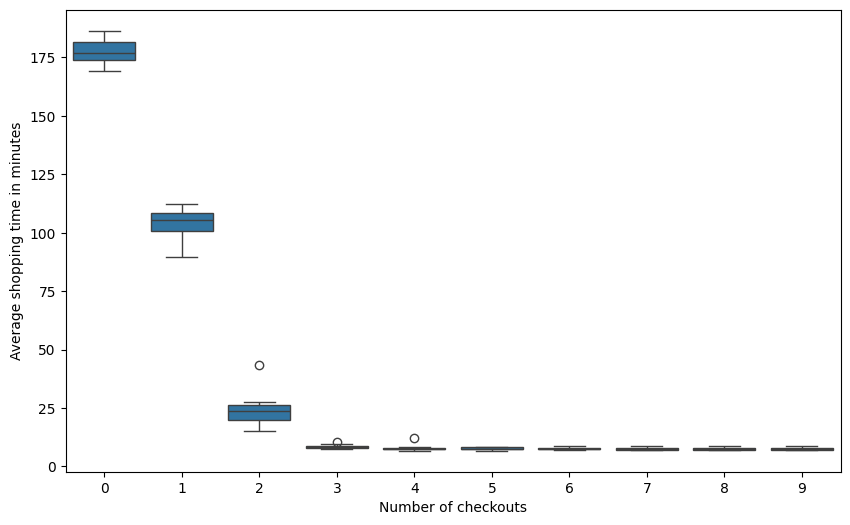

In [73]:
# df = pd.DataFrame(data = np.random.random(size=(4,4)), columns = ['A','B','C','D'])
fig, ax = plt.subplots(1,1,figsize=(10,6))
sns.boxplot(x="variable", y="value", data=df,ax=ax)

ax.set(xlabel="Number of checkouts", ylabel="Average shopping time in minutes")

ax.set_xticks(list(dict_checkout_number.keys()),list(range(10)))

plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]